In [1]:
import torch#
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt 
import sys
import time
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler

import os
from matplotlib import rcParams
rcParams['font.family'] = 'Times New Roman'

c:\Users\Scent\anaconda3\envs\CENT000\Lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 指定されたプロシージャが見つかりません。'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print("GPU name:", torch.cuda.get_device_name(0))
else:
    device = torch.device('cpu')
print(f'Using device: {device}')


GPU name: NVIDIA GeForce GTX 1660
Using device: cuda


In [3]:
home_directory = os.path.expanduser('~')
onedrive_folder_name = 'OneDrive'
onedrive_path = os.path.join(home_directory, onedrive_folder_name)

# CSVファイルの読み込み
file_path =os.path.join(onedrive_path,'CODES','samples','engine_data.csv')
data = pd.read_csv(file_path)

# データの前処理
data = data.dropna()  # 欠損値を削除

# 特徴量とターゲットに分ける
# 'Engine Condition' をターゲット変数として仮定
X = data.drop(columns=['Engine Condition'])
y_origin = data['Engine Condition']

# 特徴量を標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)#平均と標準偏差を使ってデータをスケーリング



In [4]:
def get_new_dataloader(X_scaled, y_origin, test_size=0.2, batch_size=32):
    # ランダムに分割（シャッフル付き）
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y_origin, test_size=test_size, shuffle=True
    )

    # クラス数カウント
    num_pos = (y_train == 1).sum()
    num_neg = (y_train == 0).sum()
    #print('abnormal', num_pos)
    #print('normal', num_neg)

    # Tensor変換
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

    # DataLoader 作成
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader, num_pos, num_neg

In [5]:
#EncoderIM
class Encoder(nn.Module):
    def __init__(self,input_dim, leverage):
        super(Encoder, self).__init__()
        self.leverage = leverage
        output_dim = int(input_dim // leverage)
        self.B = nn.Parameter(torch.randn(output_dim, input_dim) * (input_dim))#.to(device)
        self.B.requires_grad = False

    
    def forward(self, x):
        x = x.T
        x = torch.matmul(self.B,x)
        x = x.T
        x = torch.abs(x)**2
        return x

In [6]:

class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        mid1 = max(4, input_dim * 3)  # 入力の3倍。ただし最小4にする
        self.fc1 = nn.Linear(input_dim,mid1)
        self.fc2 = nn.Linear(mid1, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return self.fc2(x)


In [7]:
class EncoderClassifier(nn.Module):
    def __init__(self,input_dim, leverage):
        super(EncoderClassifier, self).__init__()
        potential_dim = int(input_dim//leverage)
        self.encoder = Encoder(input_dim,leverage,) 
        self.classifier =  MLP(potential_dim)
        
    def forward(self, x):
        x = self.encoder(x) 
        x = self.classifier(x)
        return x

1:1 1th Epoch: 29/30

IN [ 1.385481   -0.5870036  -0.46939006 -0.53303987 -1.0485827  -1.6554145 ]
OUT tensor([ 54.1804, 189.5009,  52.5334,  43.3514,  10.3709, 333.4332],
       device='cuda:0')


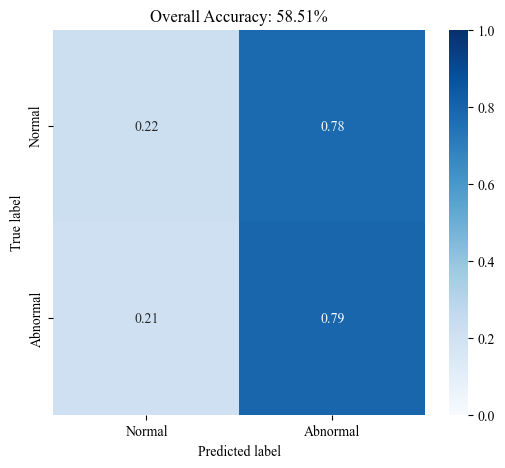

1:1 2th Epoch: 29/30

IN [-0.81179273 -1.389706    1.9341177  -0.8551948   3.5349557  -1.0974733 ]
OUT tensor([   3.3023, 2814.2590,  159.2636, 2149.8291,  548.2830,  473.8672],
       device='cuda:0')


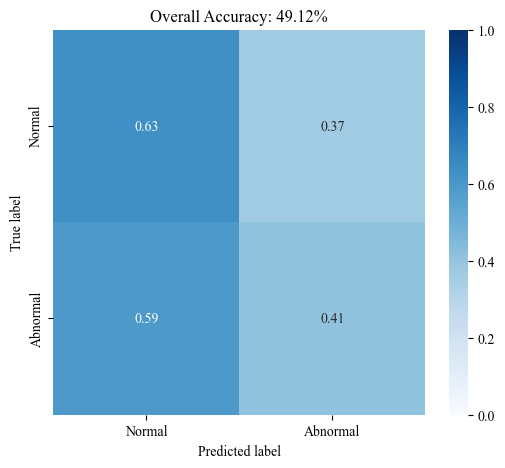

1:1 3th Epoch: 29/30

IN [ 0.5334769  -1.1698034   0.7080192  -0.8170947  -0.25190216  0.8573922 ]
OUT tensor([447.0350,  12.7203, 159.3561, 475.6559,  27.8482, 238.3953],
       device='cuda:0')


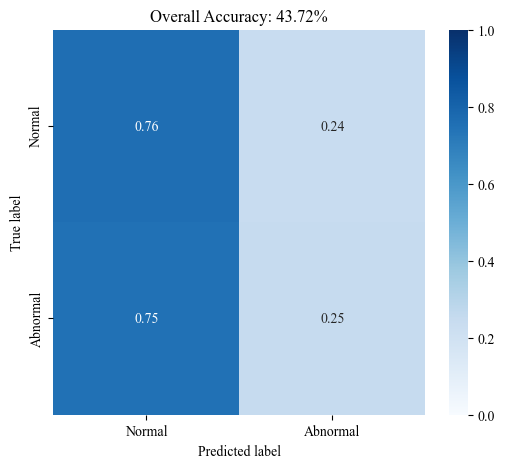

1:1 4th Epoch: 29/30

IN [-1.0546887  -0.07055656  0.25542343 -1.3281231   0.8728615   0.02304773]
OUT tensor([  6.4391,   2.6307, 102.1643, 390.1586, 770.3438, 218.9989],
       device='cuda:0')


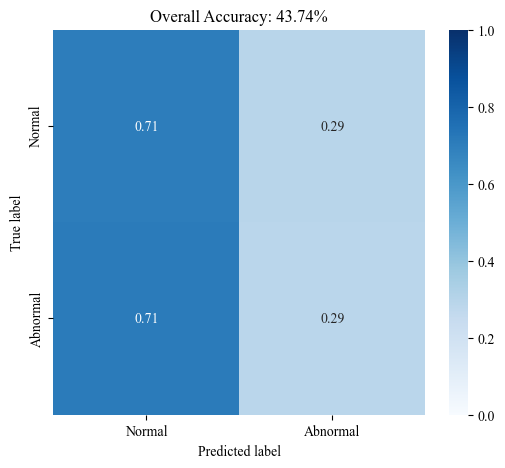

1:1 5th Epoch: 29/30

IN [ 0.00284277 -0.19266613 -1.0680357  -0.9492001  -0.99275523  0.4591932 ]
OUT tensor([  4.3203,  95.4219,  16.2540,  81.0434,   8.5474, 299.5833],
       device='cuda:0')


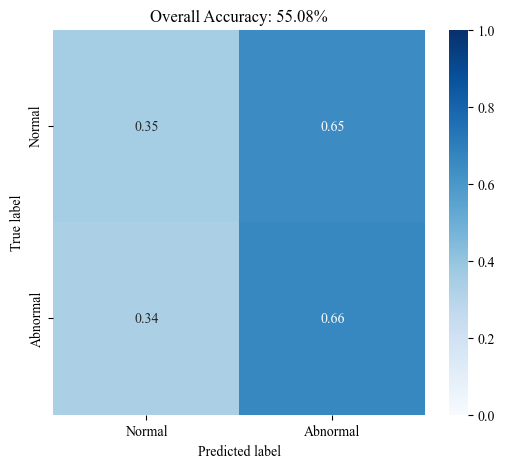

           Average  Best ID       Best  Worst ID      Worst
0   ACC  50.033274        1  58.510366         3  43.716406
1  LOSS   0.729424        3   0.686611         5   0.770866


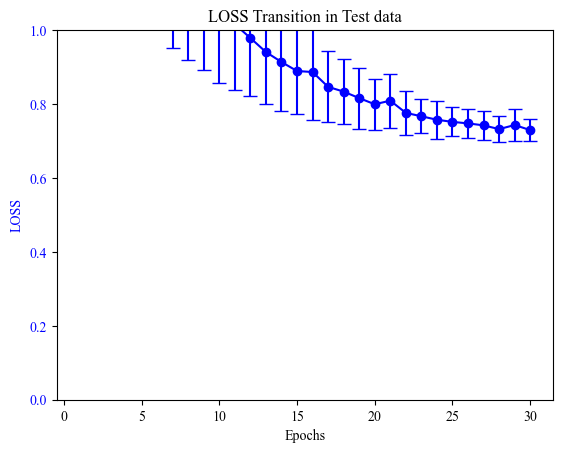

1:2 1th Epoch: 29/30

IN [ 1.4975868  -1.0075575  -0.03300548 -0.16463871 -0.7363401  -0.57856727]
OUT tensor([ 16.4984, 102.4425, 174.9478], device='cuda:0')


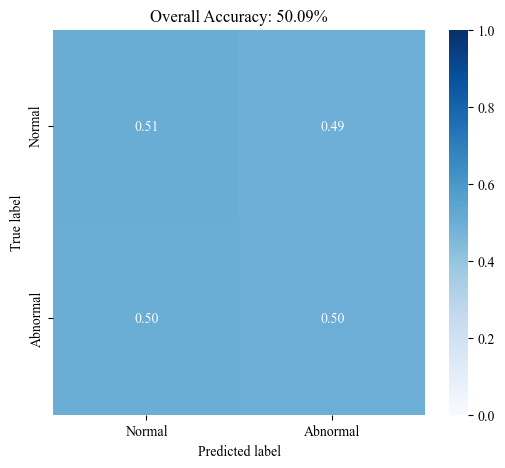

1:2 2th Epoch: 29/30

IN [-0.4792122  -0.970259   -1.4397622   0.19630896  0.26083124 -1.143636  ]
OUT tensor([45.4807,  4.3674, 21.8107], device='cuda:0')


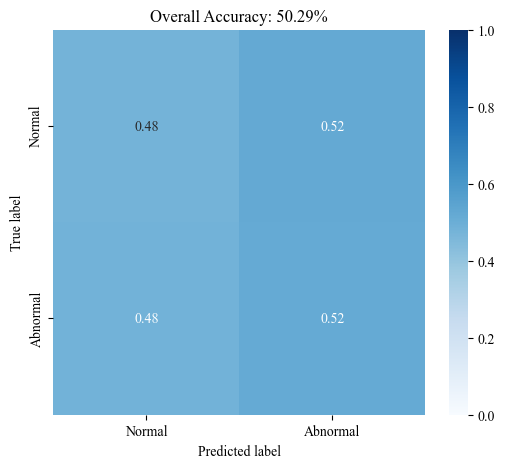

1:2 3th Epoch: 29/30

IN [-0.25873744  2.3053324  -0.13339438 -0.6959325  -1.3899238   0.5210681 ]
OUT tensor([109.1814, 131.9298, 192.7727], device='cuda:0')


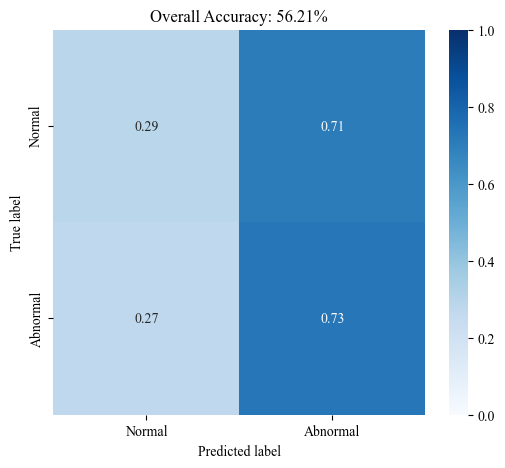

1:2 4th Epoch: 29/30

IN [-1.1481102  -0.2401205  -0.03584587 -0.7059689  -0.83988786 -0.5875033 ]
OUT tensor([961.3251,  48.7124, 200.7388], device='cuda:0')


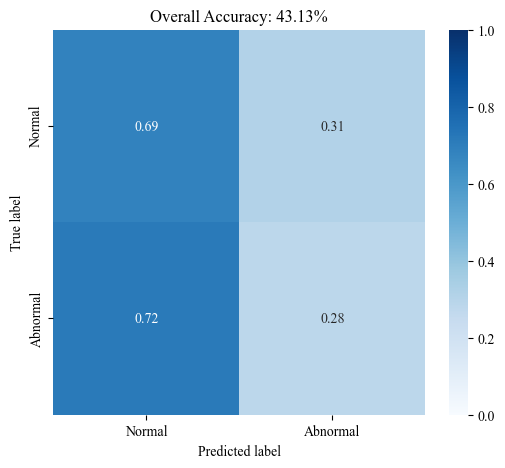

1:2 5th Epoch: 29/30

IN [ 0.3092653   0.9411476   0.5078946  -0.81717914 -0.5568621  -0.66638476]
OUT tensor([35.8700, 36.9085, 69.5551], device='cuda:0')


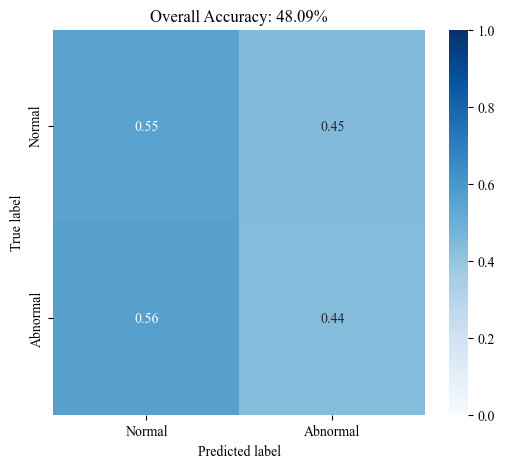

           Average  Best ID       Best  Worst ID      Worst
0   ACC  49.562324        3  56.206808         4  43.127719
1  LOSS   0.714196        2   0.661774         5   0.807095


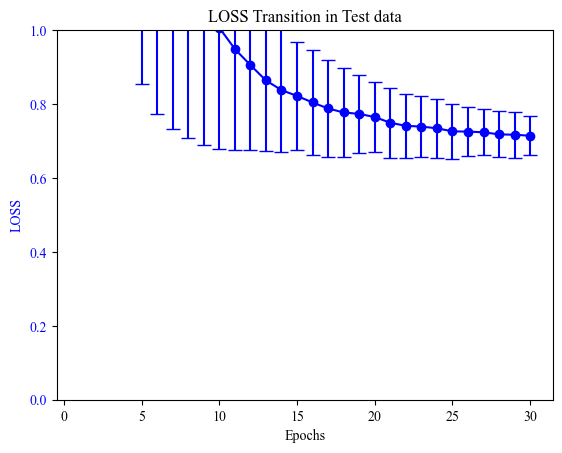

1:3 1th Epoch: 29/30

IN [-0.6810026  -0.2725155   0.06634575 -1.216655   -1.2637786   0.76660377]
OUT tensor([0.1100, 2.3208], device='cuda:0')


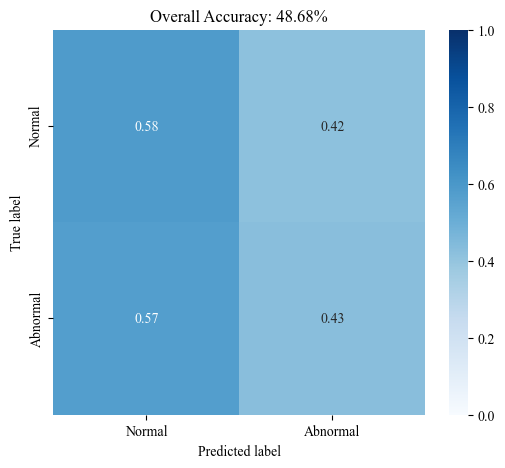

1:3 2th Epoch: 29/30

IN [-1.0509518   0.11512777  0.8414222  -0.48400515 -0.5645341   1.3031822 ]
OUT tensor([69.1774, 35.1478], device='cuda:0')


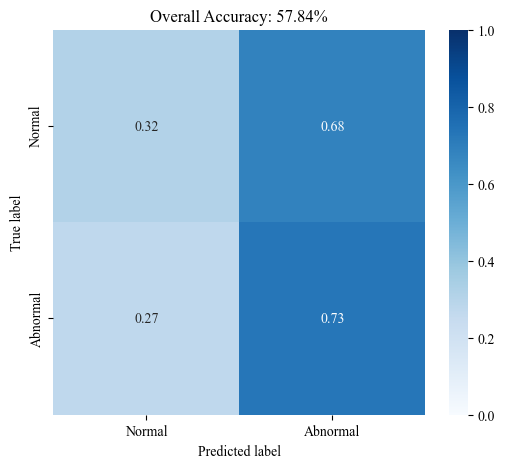

1:3 3th Epoch: 29/30

IN [-1.0397412  -0.80395967 -0.53327173  0.99361914 -0.6234215  -0.02539911]
OUT tensor([37.6023, 60.4032], device='cuda:0')


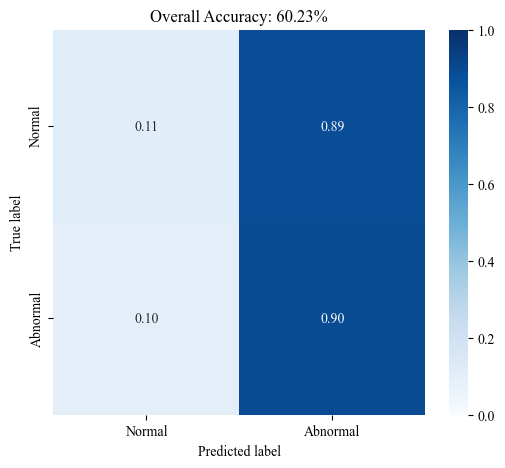

1:3 4th Epoch: 29/30

IN [ 0.7128462   0.2570507   0.8806399   0.48660955 -0.59763     0.9312282 ]
OUT tensor([106.7267,  15.0252], device='cuda:0')


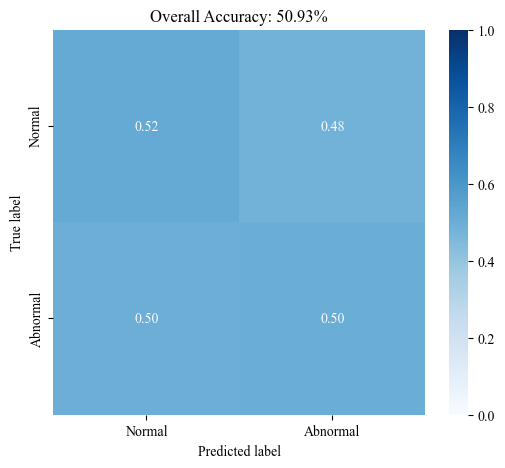

1:3 5th Epoch: 29/30

IN [-0.17278966  0.6463822   0.36010018  0.16464764  0.19999029 -1.7074155 ]
OUT tensor([102.9121, 171.7238], device='cuda:0')


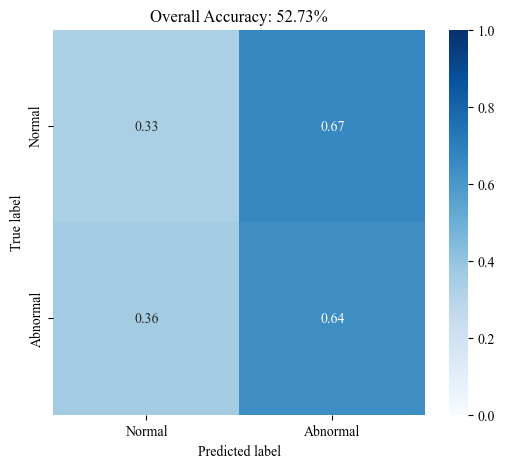

           Average  Best ID       Best  Worst ID      Worst
0   ACC  54.082416        3  60.225237         1  48.681853
1  LOSS   0.659817        2   0.656707         4   0.662221


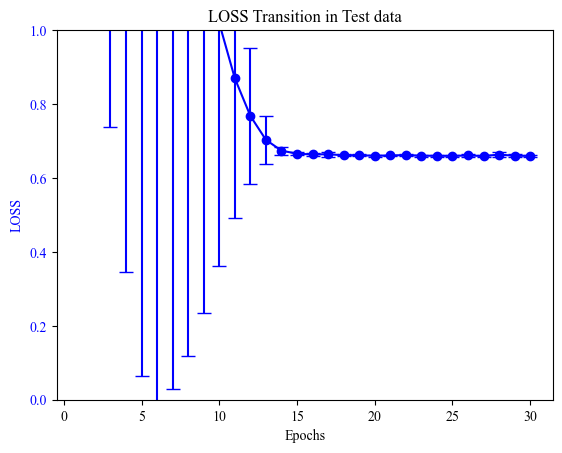

1:6 1th Epoch: 29/30

IN [ 2.7307506  -0.10764544 -1.1994717   0.87253416 -0.33634     0.1647098 ]
OUT tensor([167.4840], device='cuda:0')


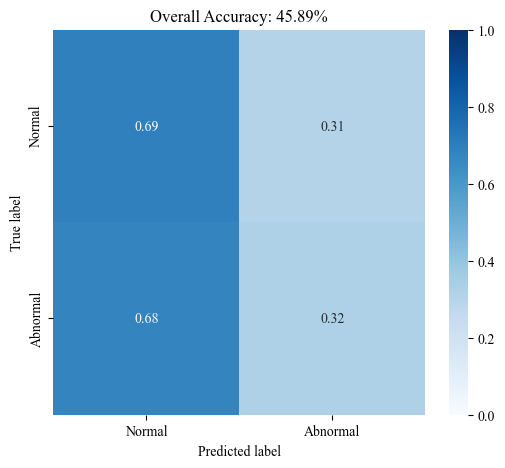

1:6 2th Epoch: 29/30

IN [-1.043478    1.4307295  -0.61911273  0.88118243 -0.39046356 -1.8611083 ]
OUT tensor([12.2990], device='cuda:0')


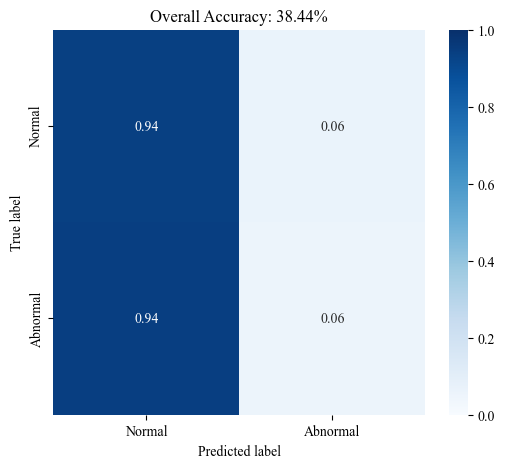

1:6 3th Epoch: 29/30

IN [-1.1182153  -1.1014608  -0.7926839  -0.39918432 -0.84609836  0.6756476 ]
OUT tensor([264.4698], device='cuda:0')


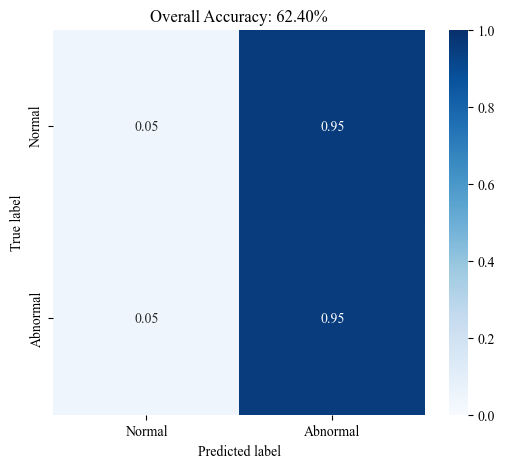

1:6 4th Epoch: 29/30

IN [-1.1219522  -0.30351964 -1.7408507   0.85002905 -0.08679288  0.57056147]
OUT tensor([263.3853], device='cuda:0')


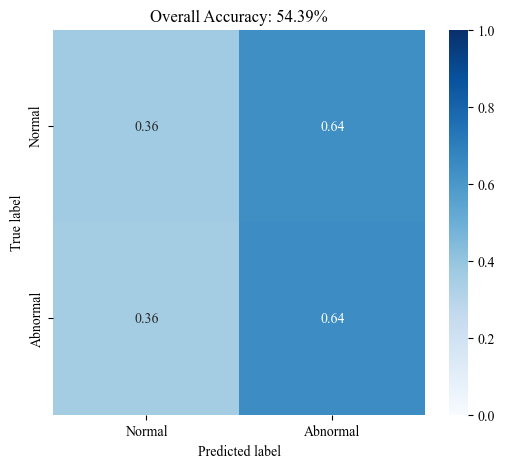

1:6 5th Epoch: 29/30

IN [-0.13542105 -0.09984066  0.33101535 -0.97366095  2.5005631  -1.8164401 ]
OUT tensor([387.4360], device='cuda:0')


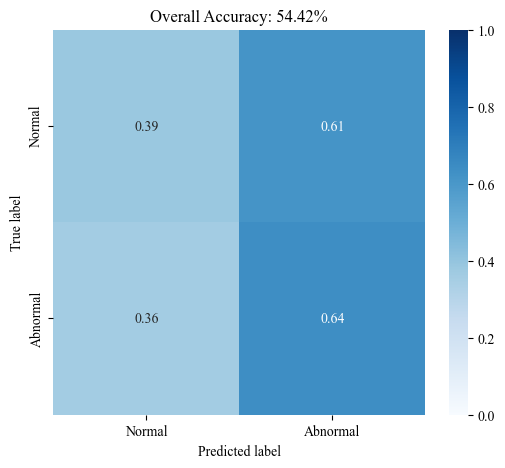

           Average  Best ID       Best  Worst ID      Worst
0   ACC  51.108267        3  62.400819         2  38.443819
1  LOSS   0.658612        4   0.649547         2   0.666728


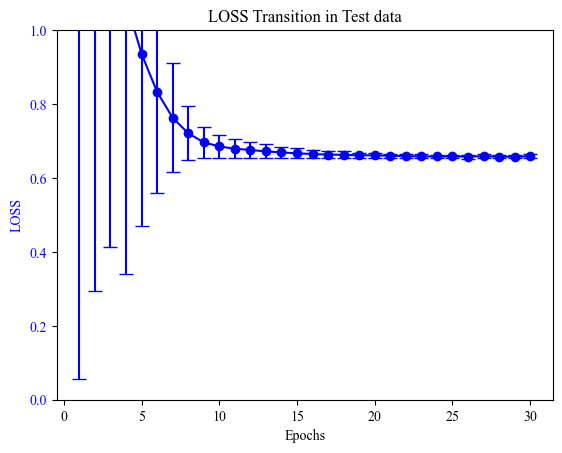

In [8]:
input_dim = X_scaled.shape[1]
max_epochs = 30 #30
lr = 1e-4 #学習率

num_try = 5 #5

leverages = [1,2,3,6]
results = []
All_last_LOSSs_ = []
All_last_ACCs_ = []
for leverage in leverages: 
    
    All_last_loss = []
    All_loss_test = []
    All_pro_time = []
    All_test_acc = []

    for num_times in range(num_try): 
        train_dataloader, test_dataloader, num_pos, num_neg = get_new_dataloader(X_scaled,y_origin)
        model = EncoderClassifier(input_dim,leverage).to(device)
        #pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float32).to(device)
        criterion = nn.BCEWithLogitsLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)
        loss_train_ = []
        loss_test_ = []
        pro_time_ = []

        for epoch in range(max_epochs):
            model.train()
            epoch_loss_train = 0
            sys.stderr.write('\r1:%d %dth Epoch: %d/%d' % (leverage,num_times+1, epoch, max_epochs))  
            sys.stderr.flush()

            start_time1 = time.time()
            for batch_X, batch_Y in train_dataloader:
                batch_X, batch_Y = batch_X.to(device), batch_Y.to(device)
                batch_Y = batch_Y.view(-1, 1)
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                loss.backward()
                optimizer.step()

                epoch_loss_train += loss.item()

            epoch_loss_train /= len(train_dataloader)
            loss_train_.append(epoch_loss_train)
            end_time1 = time.time()
            pro_time_.append(end_time1-start_time1)

            # テスト損失計算
            model.eval()
            with torch.no_grad():
                all_preds = []
                all_labels = []
                correct = 0
                total = 0
                loss_test = 0.0
                first_batch = True

                for batch_x, batch_y in test_dataloader:
                    batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                    batch_y = batch_y.view(-1, 1)
                    outputs = model(batch_x).to(device)  # 出力は sigmoid による確率

                    predicted = (outputs > 0.5).float()  # しきい値 0.5 による2値化
                    loss = criterion(outputs, batch_y)
                    loss_test += loss.item()

                    total += batch_y.size(0)
                    correct += (predicted == batch_y).sum().item()
                    all_preds.extend(predicted.cpu().numpy().astype(int))
                    all_labels.extend(batch_y.cpu().numpy().astype(int))


                    
                    if epoch == max_epochs - 1:
                        if first_batch:
                            x_encoded = model.encoder(batch_x)
                            x_in =  batch_x.detach().cpu().numpy()
                            print('IN',x_in[0])
                            print('OUT',x_encoded[0])
                            first_batch = False
            
            loss_test_avg = loss_test / len(test_dataloader)

            #loss_train_.append(loss_train_avg)
            loss_test_.append(loss_test_avg)
        All_loss_test.append(loss_test_)
        All_pro_time.append(sum(pro_time_)) 

        cm = confusion_matrix(all_labels, all_preds)
        cm_normalized = cm.astype('float') / cm.sum(axis=1, keepdims=True)  # 正規化（行ごとに割合に）

        Last_loss_test = loss_test_[-1]
        All_last_loss.append(Last_loss_test)
        Test_acc = 100 * correct / total
        All_test_acc.append(Test_acc)

        class_names = ['Normal', 'Abnormal']
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=class_names, yticklabels=class_names, vmin=0.0, vmax=1.0)
        plt.xlabel("Predicted label")
        plt.ylabel("True label")
        plt.title(f"Overall Accuracy: {Test_acc:.2f}%")
        plt.show()

    All_last_LOSSs_.append(All_last_loss)
    All_last_ACCs_.append(All_test_acc)
    
    ACC_mean = np.mean(All_test_acc)
    ACC_best = np.max(All_test_acc)
    ACC_bestID = np.argmax(All_test_acc)+1
    ACC_worst = np.min(All_test_acc)
    ACC_worstID = np.argmin(All_test_acc)+1

    LOSS_mean = np.mean(All_last_loss)
    LOSS_best = np.min(All_last_loss)
    LOSS_bestID = np.argmin(All_last_loss)+1
    LOSS_worst = np.max(All_last_loss)
    LOSS_worstID = np.argmax(All_last_loss)+1

    data = {
            "": ["ACC", "LOSS"],
        "Average": [ACC_mean, LOSS_mean],
        "Best ID": [ACC_bestID, LOSS_bestID],
        "Best": [ACC_best, LOSS_best],
        "Worst ID": [ACC_worstID, LOSS_worstID],
        "Worst": [ACC_worst, LOSS_worst],
    }

    df = pd.DataFrame(data)
    results.append(data)
    print(df)
    epochs = len(All_loss_test[0])  # エポック数（各リストの長さ）
    num_dimensions = len(All_loss_test)  # 埋め込み次元数の数

    # 各エポックごとに平均と標準偏差を計算
    mean_loss = np.mean(All_loss_test, axis=0)
    std_loss = np.std(All_loss_test, axis=0)

    # グラフの描画
    fig, ax1 = plt.subplots()

    # 平均値の折れ線グラフと誤差範囲（標準偏差の誤差棒）
    ax1.errorbar(
        x=range(1, epochs + 1), y=mean_loss, yerr=std_loss,
        fmt='-o', color='blue', ecolor='blue', capsize=5, 
    )

    # 軸ラベルやタイトルの設定
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('LOSS', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    plt.title('LOSS Transition in Test data')
    plt.ylim(0,1.0)
    plt.show()


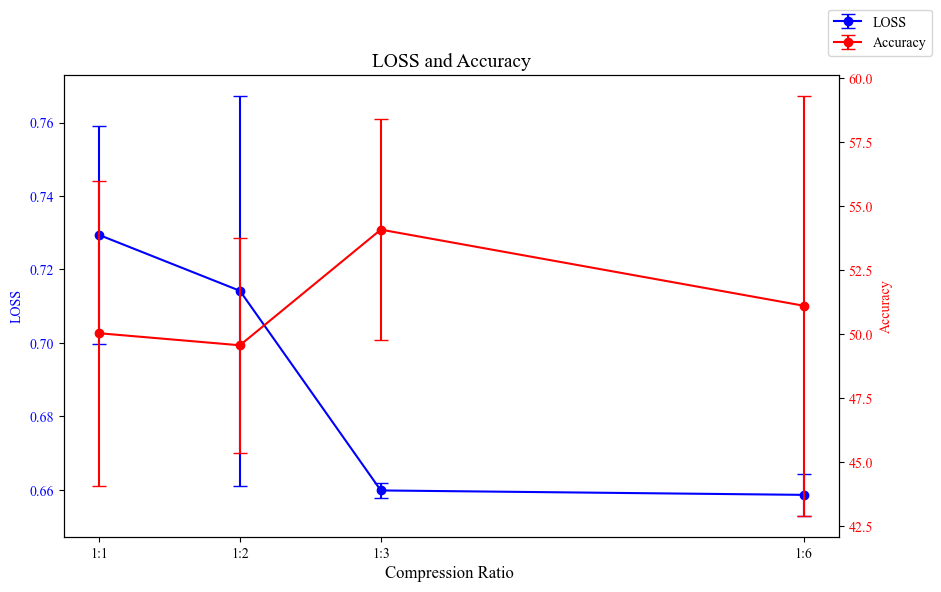

In [9]:
# 横軸の値 (1/leverage)
x_values = [leverage for leverage in leverages]
memory_lis =[1,2,3,6]

# LOSS用の平均値と標準偏差を計算
loss_means = [np.mean(loss_list) for loss_list in All_last_LOSSs_]
loss_stds = [np.std(loss_list) for loss_list in All_last_LOSSs_]

# ACC用の平均値と標準偏差を計算
acc_means = [np.mean(acc_list) for acc_list in All_last_ACCs_]
acc_stds = [np.std(acc_list) for acc_list in All_last_ACCs_]

# グラフの描画
fig, ax1 = plt.subplots(figsize=(10, 6))

# MSEのエラーバー付き折れ線グラフ
ax1.errorbar(
    x=x_values, y=loss_means, yerr=loss_stds,
    fmt='-o', color='blue', ecolor='blue', capsize=5, label='LOSS'
)
ax1.set_ylabel('LOSS', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

ax2 = ax1.twinx()
# SSIMのエラーバー付き折れ線グラフ
ax2.errorbar(
    x=x_values, y=acc_means, yerr=acc_stds,
    fmt='-o', color='red', ecolor='red', capsize=5, label='Accuracy'
)
ax2.set_ylabel('Accuracy', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# 軸ラベルとスケールの設定
ax1.set_xlabel('Compression Ratio ', fontsize=12)

ax1.set_xticks(memory_lis)
ax1.set_xticklabels([f"1:{x}" for x in memory_lis]) # ラベルを「1:N」形式で表示

# タイトルと凡例
plt.title('LOSS and Accuracy', fontsize=14)
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
fig.legend(
    lines1 + lines2, labels1 + labels2, loc="upper right", bbox_to_anchor=(1, 1)
)
plt.show()

In [10]:
all_data = pd.concat([pd.DataFrame(result) for result in results], ignore_index=True)
print(all_data)

           Average  Best ID       Best  Worst ID      Worst
0   ACC  50.033274        1  58.510366         3  43.716406
1  LOSS   0.729424        3   0.686611         5   0.770866
2   ACC  49.562324        3  56.206808         4  43.127719
3  LOSS   0.714196        2   0.661774         5   0.807095
4   ACC  54.082416        3  60.225237         1  48.681853
5  LOSS   0.659817        2   0.656707         4   0.662221
6   ACC  51.108267        3  62.400819         2  38.443819
7  LOSS   0.658612        4   0.649547         2   0.666728


In [11]:
import csv
save_directory1 = os.path.join(onedrive_path,'CODES', 'konishi_AutoEncoder', 'AutoMotive_data_001','texts') 
print(save_directory1)
os.makedirs(save_directory1, exist_ok=True)
file_name = 'MLP_VCR_IM_Class00_list.csv'##
full_path = os.path.join(save_directory1, file_name)
with open(full_path, mode='w', newline='') as file:
    writer = csv.writer(file)

    writer.writerow(All_last_LOSSs_)
    writer.writerow(All_last_ACCs_)

C:\Users\Scent\OneDrive\CODES\konishi_AutoEncoder\AutoMotive_data_001\texts
